In [1]:
from pathlib import Path
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import json

from stampextraction.vis_exposures import VisExposureFitsIO, VisExposureHDF5
from stampextraction.stamps import extract_exposure_stamp

In [4]:
#Define files
datafiles = {}
datafiles["DET"] = "EUC_SHE_VIS-DET-1-1_0_20250701T085217.429173Z_09.10.fits"
datafiles["BKG"] = "EUC_SHE_VIS-BKG-1-1_0_20250701T085217.429307Z_09.10.fits"
datafiles["WGT"] = "EUC_SHE_VIS-WGT-1-1_0_20250701T085217.429294Z_09.10.fits"
datafiles["SEG"] = "EUC_SHE_EXP-RPJ-SEG_00_20250701T085301.676748Z_09.10.fits"
datafiles["MER"] = "EUC_SHE_MER-CAT_00_20250701T085255.628039Z_09.10.fits"
datafiles["HDF5"] = "image_data.hdf5"
datapath = Path("/shared-scratch/hpcp/data")

#### The Euclid data set
144000 objects (galaxies) with a lot of properties. We only care about OBJECT_ID, RIGHT_ASCENSION and DECLINATION for this example.

In [5]:
from astropy.table import Table
t = Table.read(datapath / datafiles["MER"], memmap=False)
t[0:10]

OBJECT_ID,RIGHT_ASCENSION,DECLINATION,SEGMENTATION_MAP_ID,VIS_DET,FLUX_G_EXT_DECAM_APER,FLUX_R_EXT_DECAM_APER,FLUX_I_EXT_DECAM_APER,FLUX_Z_EXT_DECAM_APER,FLUX_U_EXT_OMEGACAM_APER,FLUX_G_EXT_OMEGACAM_APER,FLUX_R_EXT_OMEGACAM_APER,FLUX_I_EXT_OMEGACAM_APER,FLUX_U_EXT_LSST_APER,FLUX_G_EXT_LSST_APER,FLUX_R_EXT_LSST_APER,FLUX_I_EXT_LSST_APER,FLUX_Z_EXT_LSST_APER,FLUX_U_EXT_MEGACAM_APER,FLUX_R_EXT_MEGACAM_APER,FLUX_G_EXT_JPCAM_APER,FLUX_I_EXT_PANSTARRS_APER,FLUX_Z_EXT_PANSTARRS_APER,FLUX_Z_EXT_HSC_APER,FLUX_G_EXT_HSC_APER,FLUX_VIS_APER,FLUX_Y_APER,FLUX_J_APER,FLUX_H_APER,FLUXERR_G_EXT_DECAM_APER,FLUXERR_R_EXT_DECAM_APER,FLUXERR_I_EXT_DECAM_APER,FLUXERR_Z_EXT_DECAM_APER,FLUXERR_U_EXT_OMEGACAM_APER,FLUXERR_G_EXT_OMEGACAM_APER,FLUXERR_R_EXT_OMEGACAM_APER,FLUXERR_I_EXT_OMEGACAM_APER,FLUXERR_U_EXT_LSST_APER,FLUXERR_G_EXT_LSST_APER,FLUXERR_R_EXT_LSST_APER,FLUXERR_I_EXT_LSST_APER,FLUXERR_Z_EXT_LSST_APER,FLUXERR_U_EXT_MEGACAM_APER,FLUXERR_R_EXT_MEGACAM_APER,FLUXERR_G_EXT_JPCAM_APER,FLUXERR_I_EXT_PANSTARRS_APER,FLUXERR_Z_EXT_PANSTARRS_APER,FLUXERR_Z_EXT_HSC_APER,FLUXERR_G_EXT_HSC_APER,FLUXERR_VIS_APER,FLUXERR_Y_APER,FLUXERR_J_APER,FLUXERR_H_APER,FLUX_NIR_STACK_APER,FLUXERR_NIR_STACK_APER,FLUX_G_EXT_DECAM_TOTAL,FLUX_R_EXT_DECAM_TOTAL,FLUX_I_EXT_DECAM_TOTAL,FLUX_Z_EXT_DECAM_TOTAL,FLUX_U_EXT_OMEGACAM_TOTAL,FLUX_G_EXT_OMEGACAM_TOTAL,FLUX_R_EXT_OMEGACAM_TOTAL,FLUX_I_EXT_OMEGACAM_TOTAL,FLUX_U_EXT_LSST_TOTAL,FLUX_G_EXT_LSST_TOTAL,FLUX_R_EXT_LSST_TOTAL,FLUX_I_EXT_LSST_TOTAL,FLUX_Z_EXT_LSST_TOTAL,FLUX_U_EXT_MEGACAM_TOTAL,FLUX_R_EXT_MEGACAM_TOTAL,FLUX_G_EXT_JPCAM_TOTAL,FLUX_I_EXT_PANSTARRS_TOTAL,FLUX_Z_EXT_PANSTARRS_TOTAL,FLUX_Z_EXT_HSC_TOTAL,FLUX_G_EXT_HSC_TOTAL,FLUX_Y_TOTAL,FLUX_J_TOTAL,FLUX_H_TOTAL,FLUXERR_G_EXT_DECAM_TOTAL,FLUXERR_R_EXT_DECAM_TOTAL,FLUXERR_I_EXT_DECAM_TOTAL,FLUXERR_Z_EXT_DECAM_TOTAL,FLUXERR_U_EXT_OMEGACAM_TOTAL,FLUXERR_G_EXT_OMEGACAM_TOTAL,FLUXERR_R_EXT_OMEGACAM_TOTAL,FLUXERR_I_EXT_OMEGACAM_TOTAL,FLUXERR_U_EXT_LSST_TOTAL,FLUXERR_G_EXT_LSST_TOTAL,FLUXERR_R_EXT_LSST_TOTAL,FLUXERR_I_EXT_LSST_TOTAL,FLUXERR_Z_EXT_LSST_TOTAL,FLUXERR_U_EXT_MEGACAM_TOTAL,FLUXERR_R_EXT_MEGACAM_TOTAL,FLUXERR_G_EXT_JPCAM_TOTAL,FLUXERR_I_EXT_PANSTARRS_TOTAL,FLUXERR_Z_EXT_PANSTARRS_TOTAL,FLUXERR_Z_EXT_HSC_TOTAL,FLUXERR_G_EXT_HSC_TOTAL,FLUXERR_Y_TOTAL,FLUXERR_J_TOTAL,FLUXERR_H_TOTAL,FLUX_VIS_PSF,FLUXERR_VIS_PSF,FLUX_SEGMENTATION,FLUXERR_SEGMENTATION,FLUX_DETECTION_TOTAL,FLUXERR_DETECTION_TOTAL,FLAG_G_EXT_DECAM,FLAG_R_EXT_DECAM,FLAG_I_EXT_DECAM,FLAG_Z_EXT_DECAM,FLAG_U_EXT_OMEGACAM,FLAG_G_EXT_OMEGACAM,FLAG_R_EXT_OMEGACAM,FLAG_I_EXT_OMEGACAM,FLAG_U_EXT_LSST,FLAG_G_EXT_LSST,FLAG_R_EXT_LSST,FLAG_I_EXT_LSST,FLAG_Z_EXT_LSST,FLAG_U_EXT_MEGACAM,FLAG_R_EXT_MEGACAM,FLAG_G_EXT_JPCAM,FLAG_I_EXT_PANSTARRS,FLAG_Z_EXT_PANSTARRS,FLAG_Z_EXT_HSC,FLAG_G_EXT_HSC,FLAG_VIS,FLAG_Y,FLAG_J,FLAG_H,FLAG_NIR_STACK,AVG_TRANS_WAVE_G_EXT_DECAM,AVG_TRANS_WAVE_R_EXT_DECAM,AVG_TRANS_WAVE_I_EXT_DECAM,AVG_TRANS_WAVE_Z_EXT_DECAM,AVG_TRANS_WAVE_U_EXT_OMEGACAM,AVG_TRANS_WAVE_G_EXT_OMEGACAM,AVG_TRANS_WAVE_R_EXT_OMEGACAM,AVG_TRANS_WAVE_I_EXT_OMEGACAM,AVG_TRANS_WAVE_U_EXT_LSST,AVG_TRANS_WAVE_G_EXT_LSST,AVG_TRANS_WAVE_R_EXT_LSST,AVG_TRANS_WAVE_I_EXT_LSST,AVG_TRANS_WAVE_Z_EXT_LSST,AVG_TRANS_WAVE_U_EXT_MEGACAM,AVG_TRANS_WAVE_R_EXT_MEGACAM,AVG_TRANS_WAVE_G_EXT_JPCAM,AVG_TRANS_WAVE_I_EXT_PANSTARRS,AVG_TRANS_WAVE_Z_EXT_PANSTARRS,AVG_TRANS_WAVE_Z_EXT_HSC,AVG_TRANS_WAVE_G_EXT_HSC,AVG_TRANS_WAVE_VIS,AVG_TRANS_WAVE_Y,AVG_TRANS_WAVE_J,AVG_TRANS_WAVE_H,DEBLENDED_FLAG,PARENT_ID,PARENT_VISNIR,BLENDED_PROB,SHE_FLAG,VARIABLE_FLAG,BINARY_FLAG,POINT_LIKE_FLAG,POINT_LIKE_PROB,EXTENDED_FLAG,EXTENDED_PROB,SPURIOUS_FLAG,SPURIOUS_PROB,MAG_STARGAL_SEP,DET_QUALITY_FLAG,MU_MAX,MUMAX_MINUS_MAG,SEGMENTATION_AREA,A_IMAGE,POSITION_ANGLE,ELLIPTICITY,CONCENTRATION,ASYMMETRY,SMOOTHNESS,GINI,MOMENT_20,A_IMAGE_ERR,POSITION_ANGLE_ERR,ELLIPTICITY_ERR,CONCENTRATION_ERR,ASYMMETRY_ERR,SMOOTHNESS_ERR,GINI_ERR,MOMENT_20_ERR,GAL_EBV,GAL_EBV_ERR
int64,float64,float64,int64,int16,float32,float32,float32,float32,float32,float32,float32,float32,float

Lets have a look at the detector file. A FITS file with 3 extensions for each quadrant. We have a grid of 6x6 CCDs, each consists of 4 quadrants. So the FITS file contains 432 HDUs:
*  SCI: VIS science imag
*  RMS: quadrant readout noise
*  FLG: quality-control image 

In [6]:
hdu_list = fits.open(datapath / datafiles["DET"])
hdu_list.info()

Filename: /shared-scratch/hpcp/data/EUC_SHE_VIS-DET-1-1_0_20250701T085217.429173Z_09.10.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     192   ()      
  1  1-1.E.SCI     1 ImageHDU        65   (2048, 2048)   float32   
  2  1-1.E.RMS     1 ImageHDU        65   (2048, 2048)   float32   
  3  1-1.E.FLG     1 ImageHDU        65   (2048, 2048)   int32   
  4  1-1.F.SCI     1 ImageHDU        65   (2048, 2048)   float32   
  5  1-1.F.RMS     1 ImageHDU        65   (2048, 2048)   float32   
  6  1-1.F.FLG     1 ImageHDU        65   (2048, 2048)   int32   
  7  1-1.G.SCI     1 ImageHDU        65   (2048, 2048)   float32   
  8  1-1.G.RMS     1 ImageHDU        65   (2048, 2048)   float32   
  9  1-1.G.FLG     1 ImageHDU        65   (2048, 2048)   int32   
 10  1-1.H.SCI     1 ImageHDU        65   (2048, 2048)   float32   
 11  1-1.H.RMS     1 ImageHDU        65   (2048, 2048)   float32   
 12  1-1.H.FLG     1 ImageHDU        65   (2048, 204

Let us have a closer look at a single image of a single quadrant:

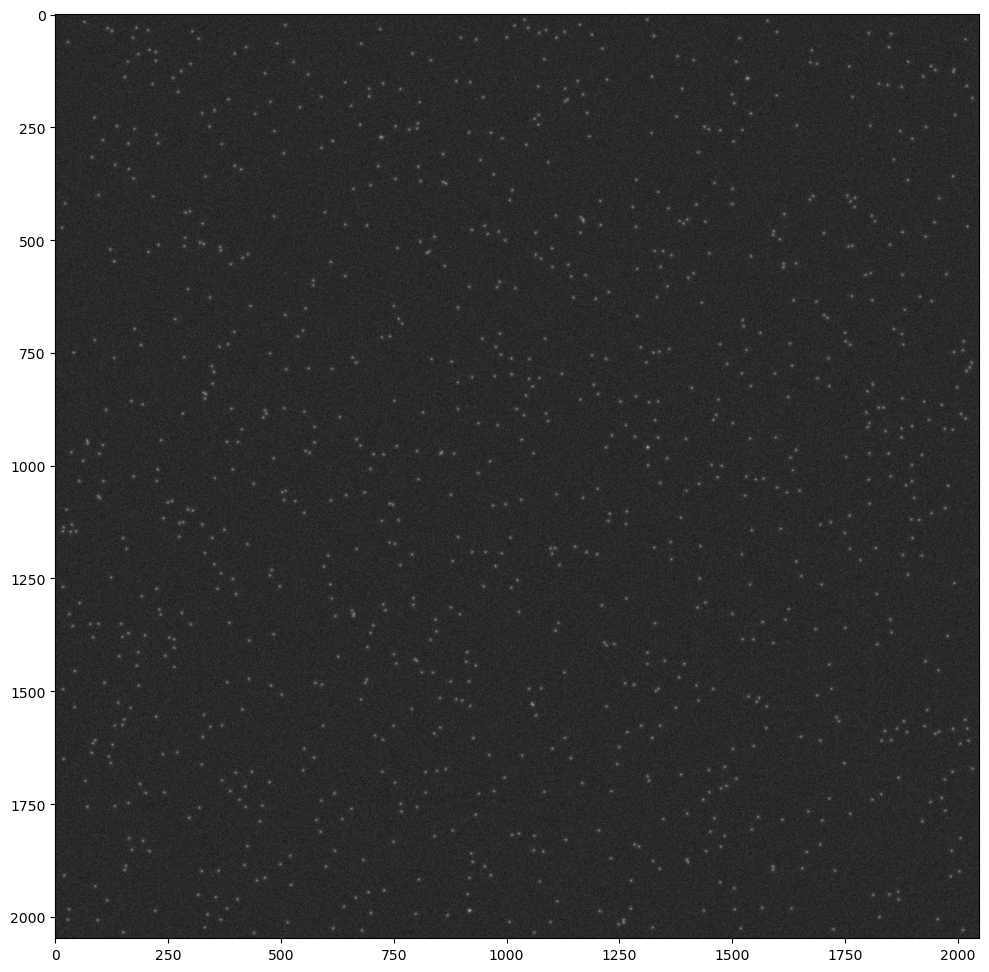

In [7]:
plt.figure(figsize = (12,12))
plt.imshow(hdu_list[1].data, cmap="gray")

This is a simulated image, with uniform sources. Perfectly for our use case: For each source make a cut-out of the image (called a stamp) and then do some processing on this.
A real Euclid image looks quiet differently, like this:
![GPU Basics Slide](img/VIS_exposure.png)
src: https://arxiv.org/pdf/2503.15303

We create a json file called shuffled_batches.json. It contain a json dump of List[List[int]]. Each inner list is a batch to process by one process. Splitedinto 1000 batches and randomly ortganized. This is the worst case access pazttern for our shared file system. 

In [8]:
shuffled_ids = np.random.permutation([i for i in range(len(t))])
shuffled_batches = [[int(i) for i in batch] for batch in np.array_split(shuffled_ids, 1000)]
with open("profiling/shuffled_batches.json", "w") as f:
    json.dump(shuffled_batches, f)

### Task 1
Create a shell script (profiling/stamp_processing_fits_shuffled.sh). It should execute the following command:

conda run -n hpcp mpirun python execute_on_batch.py shuffled fits

This command will execute the stamp extraction. Each MPI rank will load a batch (so only 2 out of the 1000 batches get processed by default) and iterate over all object IDs in this match. For each object it will create a cut-out of the galaxy. There is no processing on the stamp followed, it will execute a time.sleep(0.5) which will mimic the processing time.
The script will be called using sbatch, so Include SBATCH hints, such that 2 tasks get executed by default.

There is additional stuff needed to get the mpirun command to work. What do we need to add into the script? Let us discuss this in class.

In [19]:
%%writefile profiling/stamp_processing_fits_shuffled.sh
#!/bin/bash

#SBATCH --ntasks=2

module load anaconda
cd /psi/home/${USER}/HS25/04_Advanced
export PYTHONPATH=/psi/home/${USER}/HS25/04_Advanced:$PYTHONPATH
conda run -p /data/user/ext-marcin_s/conda-envs/hpcp mpirun python stampextraction/execute_on_batch.py

Overwriting profiling/stamp_processing_fits_shuffled.sh


In [20]:
!chmod +x profiling/stamp_processing_fits_shuffled.sh

Let's give it a try and execute it on the cluster!

In [20]:
%%bash --out job_id
sbatch --output=stamp_processing_fits_shuffled.out profiling/stamp_processing_fits_shuffled.sh | awk '{print $4}'

In [24]:
!sacct -j {job_id.strip()}

JobID           JobName  Partition    Account  AllocCPUS      State ExitCode 
------------ ---------- ---------- ---------- ---------- ---------- -------- 
27182057     stamp_pro+    general     merlin          4  COMPLETED      0:0 
27182057.ba+      batch                merlin          4  COMPLETED      0:0 
27182057.ex+     extern                merlin          4  COMPLETED      0:0 


In [32]:
!pwd

/psi/home/ext-marcin_s/HS25/04_Advanced


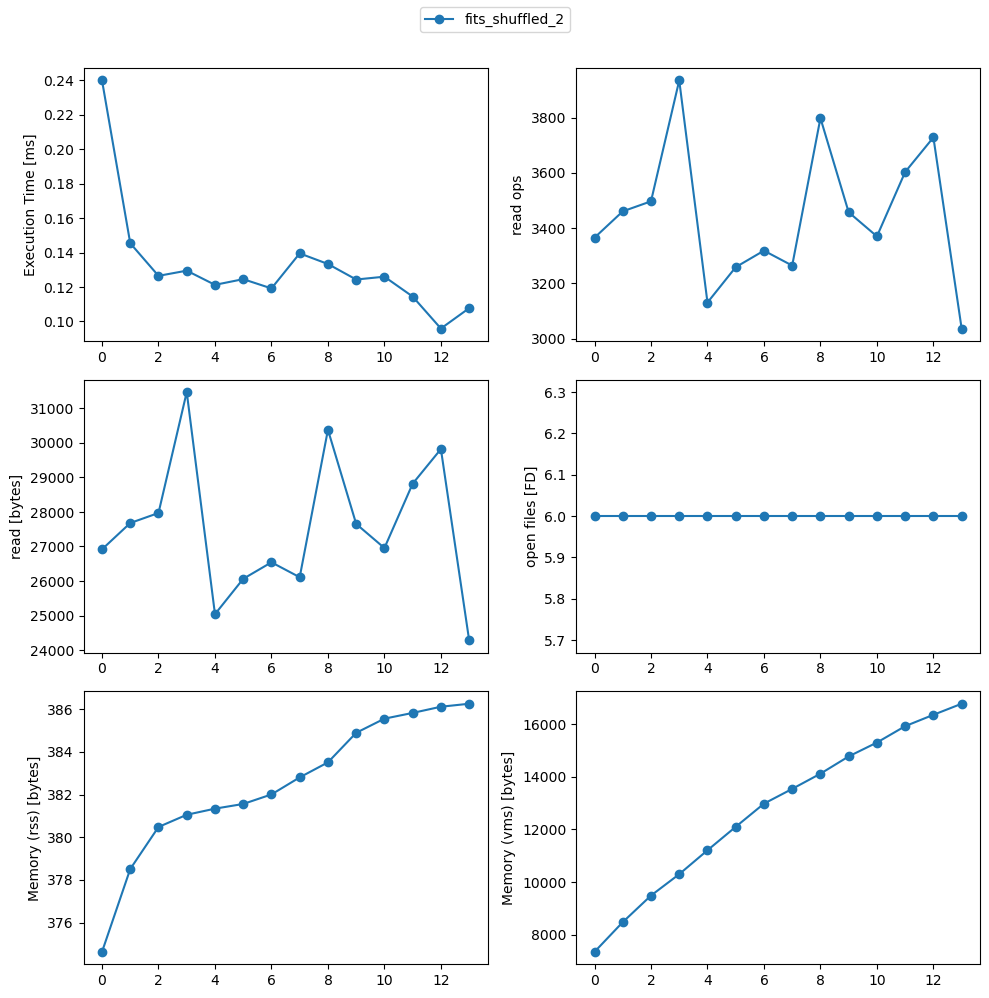

In [25]:
def plot_profiling(file_types=["fits", "hdf5"], sorting_types=["shuffled", "sorted"], sizes=[1,2,4,8,16,32,64,128,256,512]):
    fig, axs = plt.subplots(3, 2, figsize=(10, 10))
    for file_type in file_types:
        for sorting_type in sorting_types:
            for size in sizes:
                if os.path.exists(f"profiling/profiling_{file_type}_{sorting_type}_{size}.json"):
                    with open(f"profiling/profiling_{file_type}_{sorting_type}_{size}.json") as f:
                        json_list = [json.loads(line) for line in f]
                    ticks = [item["tick"] for item in json_list]
                    walltime = [item["walltime"] for item in json_list]
                    axs[0,0].plot(ticks, walltime, marker='o', label=f"{file_type}_{sorting_type}_{size}")
                    axs[0,0].set_ylabel("Execution Time [ms]")
                    read_ops = [item["read_ops"] for item in json_list]
                    axs[0,1].plot(ticks, read_ops, marker='o', label=f"{file_type}_{sorting_type}_{size}")
                    axs[0,1].set_ylabel("read ops")
                    read_bytes = [item["read"] for item in json_list]
                    axs[1,0].plot(ticks, read_bytes, marker='o', label=f"{file_type}_{sorting_type}_{size}")
                    axs[1,0].set_ylabel("read [bytes]")
                    open_files = [item["open_files"] for item in json_list]
                    axs[1,1].plot(ticks, open_files, marker='o', label=f"{file_type}_{sorting_type}_{size}")
                    axs[1,1].set_ylabel("open files [FD]")
                    rss = [item["rss"] for item in json_list]
                    axs[2,0].plot(ticks, rss, marker='o', label=f"{file_type}_{sorting_type}_{size}")
                    axs[2,0].set_ylabel("Memory (rss) [bytes]")
                    vms = [item["vms"] for item in json_list]
                    axs[2,1].plot(ticks, vms, marker='o', label=f"{file_type}_{sorting_type}_{size}")
                    axs[2,1].set_ylabel("Memory (vms) [bytes]")
    
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=len(labels))
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_profiling()

Let increase the number of processes and check if this impacts performance

In [26]:
%%bash --out job_id
sbatch --ntasks=32 --output=stamp_processing_fits_shuffled.out profiling/stamp_processing_fits_shuffled.sh | awk '{print $4}'

In [27]:
!sacct -j {job_id.strip()}

JobID           JobName  Partition    Account  AllocCPUS      State ExitCode 
------------ ---------- ---------- ---------- ---------- ---------- -------- 
27182073     stamp_pro+    general     merlin         64    RUNNING      0:0 
27182073.ba+      batch                merlin         64    RUNNING      0:0 
27182073.ex+     extern                merlin         64    RUNNING      0:0 
